In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wrds

In [2]:
db = wrds.Connection(wrds_username="thomas_bienaime")
#db.create_pgpass_file()

Enter your WRDS username [thomas_bienaime]:grimaux
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [3]:
def create_database(name,permno):
    """ 
    Doanload the stock ask to download and return it in a DataFrame
    
    """
    data = db.raw_sql("select date, ret from crsp.dsf where permno in ( "
                                  +str(permno[0])+
                                  ") and date >='2011-01-01' and date <= '2021-12-31'")
    Final_tab = data
    Final_tab=Final_tab.rename(columns={"ret": name[0]})
    #print(Final_tab)
    for i in range (1,len(permno)):
        data = db.raw_sql("select date, ret from crsp.dsf where permno in ( "
                                  +str(permno[i])+
                                  ") and date >='2011-01-01' and date <= '2021-12-31'")
        
        Final_tab=pd.merge(Final_tab,data,on='date')
        Final_tab=Final_tab.rename(columns={"ret": name[i]})
    Final_tab =Final_tab.set_index(['date'])
    return Final_tab

In [5]:
assets = create_database(["NFLX"], [89393])
data = db.raw_sql("""select date, vwretd 
                    from crsp.dsi
                    where date>='2011-01-01' 
                    and date<= '2021-12-31'""")
market = data.rename(columns = {'vwretd' : 'market'})
assets = pd.merge(assets, market, on = 'date')
data = db.raw_sql("""select caldt, tdyld 
                    from crsp.tfz_dly_rf2
                    where kytreasnox = 2000061 and
                    caldt>='2011-01-01' 
                    and caldt<= '2021-12-31'""")
short_bill = data.rename(columns = {'caldt':'date','tdyld' : 'short bill'})
assets=  pd.merge(assets, short_bill, on = "date")
#assets

                NFLX
date                
2011-01-03  0.015424
2011-01-04  0.016591
2011-01-05 -0.009042
2011-01-06 -0.009681
2011-01-07  0.007360
...              ...
2021-12-27 -0.001580
2021-12-28 -0.003931
2021-12-29 -0.000278
2021-12-30  0.002539
2021-12-31 -0.015766

[2769 rows x 1 columns]


In [5]:
def beta(data : pd.DataFrame, stock_name) :
    """ Return the beta of the stock for the given data
    """
    y = data[stock_name] -data["short bill"]
    x = data["market"] - data["short bill"]
    y_x = pd.DataFrame(data = {"y" : y, "x":x})
    cov_matrix = y_x.cov()
    return cov_matrix["x"]["y"]/cov_matrix["x"]["x"]

In [6]:
day_in_6month = 126
betas_temp = []
for i in range(0,len(assets)-day_in_6month) :
    j = i+day_in_6month
    betas_temp.append(beta(assets[i:j], "NFLX"))

<AxesSubplot:xlabel='date'>

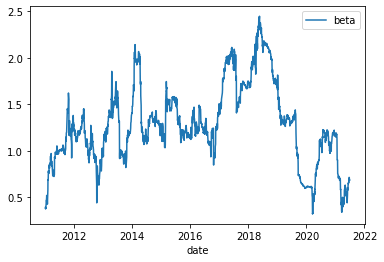

In [7]:
betas= pd.DataFrame(index = assets["date"][:-day_in_6month], data = {"beta" : betas_temp})
betas.plot()

In [8]:
beta_mean = betas.mean().values
beta_10y = beta(assets, "NFLX")
idiosyncratic_risk_stock = assets["NFLX"].var()- beta_10y**2*assets["market"].var()

epsilon  = pd.DataFrame(np.random.normal(scale = np.sqrt(idiosyncratic_risk_stock) 
                                         ,size = (len(assets))))
assets["sims"] = assets["short bill"] + beta_mean*(assets["market"]-assets["short bill"]) + epsilon[0]

In [9]:
day_in_6month = 126
betas_estim = []
for i in range(0,len(assets)-day_in_6month) :
    j = i+day_in_6month
    betas_estim.append(beta(assets[i:j], "sims"))
betas_estim = np.array(betas_estim)
beta_adj = (2.0/3.0)*betas_estim + (1.0/3.0)

<AxesSubplot:xlabel='date'>

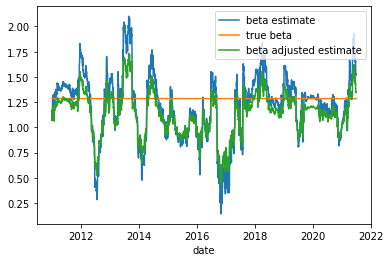

In [10]:
betas= pd.DataFrame(index = assets["date"][:-day_in_6month], data = {"beta estimate" : betas_estim, "true beta" :[beta_mean[0]]*len(betas_estim), "beta adjusted estimate" : beta_adj })
betas.plot()